In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import os

from dataset import LinemodDataset
from utils.evaluation_metrics import average_distance, average_distance_symmetric
from model.network import get_prediction_from_model_output

In [2]:
dataset_path = 'data/Linemod_preprocessed'
path_to_trained_model = 'posenet.pt'
path_to_plot_dir = 'plots/'

In [3]:
dataset = LinemodDataset(mode="eval", dataset_path=dataset_path, cloud_pt_num=500)
# list of object ids
object_list = dataset.objects
# indices of symmetric objects in object list
symmetric_object_indices = dataset.get_sym_list()
object_names = {
    1: "ape",
    2: "benchvise",
    4: "camera",
    5: "can",
    6: "cat",
    8: "driller",
    9: "duck",
    10: "eggbox",
    11: "glue",
    12: "holepuncher",
    13: "iron",
    14: "lamp",
    15: "phone"
}
# indices of the scenes in the dataset that will be plotted and evaluated (chosen so that each object appears once)
indices = [500, 1500, 2500, 3500, 4500, 5500, 6500, 7500, 8500, 9500, 10500, 11500, 12500]
model = torch.load(path_to_trained_model, map_location=torch.device('cpu'))

/home/iris/3DCV-Project/venv/lib/python3.8/site-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


ADD(-S) metric of ape: 0.004747889004647732
ADD(-S) metric less than 10% of object diameter: yes
ADD(-S) metric of benchvise: 0.02098134532570839
ADD(-S) metric less than 10% of object diameter: yes
ADD(-S) metric of camera: 0.005799351260066032
ADD(-S) metric less than 10% of object diameter: yes
ADD(-S) metric of can: 0.012769835069775581
ADD(-S) metric less than 10% of object diameter: yes
ADD(-S) metric of cat: 0.007598101161420345
ADD(-S) metric less than 10% of object diameter: yes
ADD(-S) metric of driller: 0.015018012374639511
ADD(-S) metric less than 10% of object diameter: yes
ADD(-S) metric of duck: 0.0029777619056403637
ADD(-S) metric less than 10% of object diameter: yes
ADD(-S) metric of eggbox: 0.007659404072910547
ADD(-S) metric less than 10% of object diameter: yes
ADD(-S) metric of glue: 0.007036400958895683
ADD(-S) metric less than 10% of object diameter: yes
ADD(-S) metric of holepuncher: 0.006041765213012695
ADD(-S) metric less than 10% of object diameter: yes
ADD(

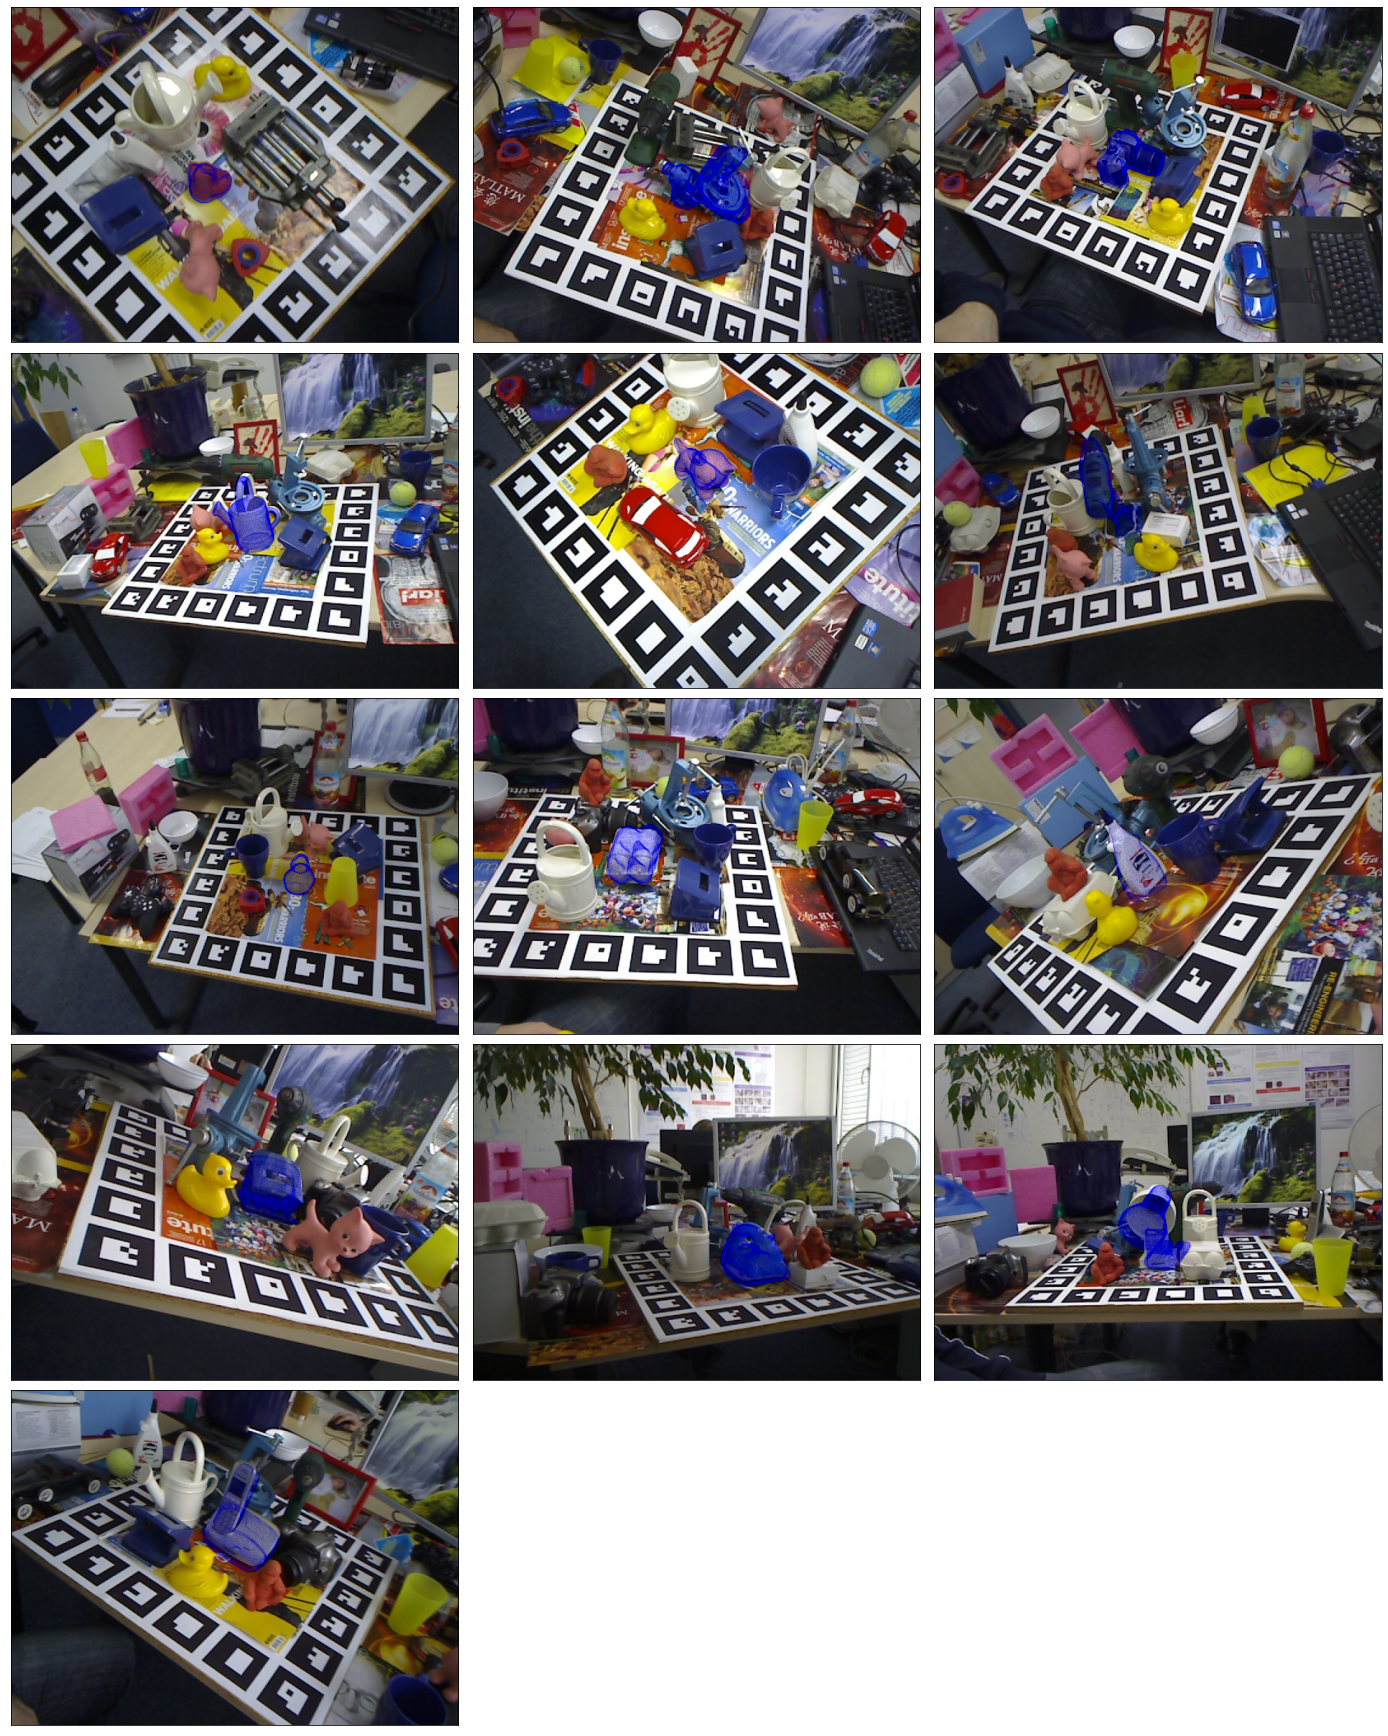

In [4]:
fig, axes = plt.subplots(ncols=3, nrows=int(np.ceil(len(indices) / 3)), sharex=True, sharey=True, figsize=(19.2, 24), constrained_layout=True)

for i, index in enumerate(indices):
    # cloud: object point cloud, shape: 500 x 3
    # choice: mask to obtain the object point cloud, shape: 1 x 500
    # img_crop: rgb image cropped to the bounding box of the object, shape: 3 x bounding_box_length x bounding_box_length
    # target_t: unit vectors pointing from each object point to the ground truth center, shape: 500 x 3
    # target_r: model points with ground truth rotation from model to camera coordinates applied, shape: 500 x 3
    # model_vtx: model vertices (downsampled to 500), shape: 500 x 3
    # obj_idx: index of the object in the list of object ids, shape: 1
    # gt_t: ground truth vector to object center, shape: 3
    cloud, choice, img_crop, target_t, target_r, model_vtx, obj_idx, gt_t = dataset[index]

    # pred_r: predicted rotations as quaternions, one per rotation anchor, shape: 1 x num_rot_anchors x 4
    # pred_t: predicted unit vectors pointing from each object point to its center, shape: 1 x 500 x 3
    # pred_c: predicted unit vectors pointing from each object point to its center, shape: 1 x num_rot_anchors
    pred_r, pred_t, pred_c = model(img_crop.unsqueeze(0), cloud.unsqueeze(0), choice.unsqueeze(0), obj_idx.unsqueeze(0))
    # pred_r: final estimate of the rotation matrix, shape: 3 x 3
    # pred_t: final estimate of the translation vector, shape: 1 x 3
    pred_r, pred_t = get_prediction_from_model_output(pred_r, pred_t, pred_c, cloud.unsqueeze(0))

    object_id = object_list[obj_idx.item()]
    model_points = dataset.get_all_model_vertices(object_id)

    # model points with the predicted transformation to camera coordinates applied
    obj_in_cam_coord = np.dot(model_points, pred_r.T) + pred_t

    cam_matrix = dataset.get_camera_matrix()

    # transform from camera coordinates to image coordinates
    obj_in_img_coord = np.dot(obj_in_cam_coord, cam_matrix.T)
    # ensure that the z entry is 1 to get image coordinates as homogeneous coordinates
    obj_in_img_coord = obj_in_img_coord / np.array([obj_in_img_coord[:, 2]]).T

    # the rgb image
    rgb = Image.open(dataset.rgb_list[index])

    axes[int(i / 3), int(i % 3)].imshow(rgb)
    # plot the model points
    axes[int(i / 3), int(i % 3)].scatter(obj_in_img_coord[:, 0], obj_in_img_coord[:, 1], color="blue", marker=".", alpha=0.05, s=1)

    # evaluate
    # downsampled ground truth object points in camera coordinates
    target = target_r.numpy() + gt_t.numpy()
    model_vtx = model_vtx.numpy()
    # object points with predicted transformation to camera coordinates applied
    pred = np.dot(model_vtx, pred_r.T) + pred_t

    # compute ADD(-S) metric
    if obj_idx.item() in symmetric_object_indices:
        # ADD-S metric
        distance = average_distance_symmetric(torch.Tensor(pred), torch.Tensor(target))
    else:
        # ADD metric
        distance = average_distance(torch.Tensor(pred), torch.Tensor(target))

    obj_diameter = dataset.get_obj_diameter(object_id)

    print(f"ADD(-S) metric of {object_names[object_id]}: {distance}")
    passed = "yes" if distance < 0.1 * obj_diameter else "no"
    print(f"ADD(-S) metric less than 10% of object diameter: {passed}")

# remove empty axes from plot
for i in range(len(indices), int(np.ceil(len(indices) / 3)) * 3):
    fig.delaxes(axes[int(i / 3), int(i % 3)])

plt.xticks([])
plt.yticks([])
plt.savefig(os.path.join(path_to_plot_dir, 'visualization.png'))
plt.show()